# 1D synthesis

### Load 1D solar model from Allen's Astrophysical Quantities

In [12]:
import numpy as np
from io import StringIO
from scipy.interpolate import interp1d
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from numba import njit
import pysolrad
np.seterr(divide='ignore', invalid='ignore')

# gather initial data
with open('./models/Allen-Solar-Atmosphere.txt', 'r', encoding='utf-8') as f:
    text = f.read()
text_fixed = text.replace('–', '-')
data = np.loadtxt(StringIO(text_fixed), skiprows=1)[:, 1:]
data = data[data[:, 0] >= 0] # filter by positive heights
height = data[:,0]*1000.*100. # heights
temp = data[:,2] # temperatures
ne = data[:,8]
pg = data[:, 4] # gas pressures
ptot = data[:, 5]  # total pressures
pmag = np.clip(ptot - pg, 0, None)  # magnetic pressures
blos = np.sqrt(8 * np.pi * pmag) # magnetic field along LOS

# BLOS approximation by power law
B0 = 300.0 # at base height - G 
h0 = 1.5e9 # cm
alpha = 4.0
blos_exp = B0 * np.exp(-height / h0)
blos_pow = B0 * (h0 / (height + h0))**alpha
blos=blos_pow

# interpolate model quantities
n_points = height.size * 10
heights = np.linspace(height.min(), height.max(), n_points)
tempInt = interp1d(height, temp, kind='linear', fill_value='extrapolate')
neInt = interp1d(height, ne, kind='linear', fill_value='extrapolate')
blosInt = interp1d(height, blos, kind='linear', fill_value='extrapolate')
temp = tempInt(heights)
ne = neInt(heights)
blos = blosInt(heights)
dl = np.abs(np.diff(heights)) # difference in heights

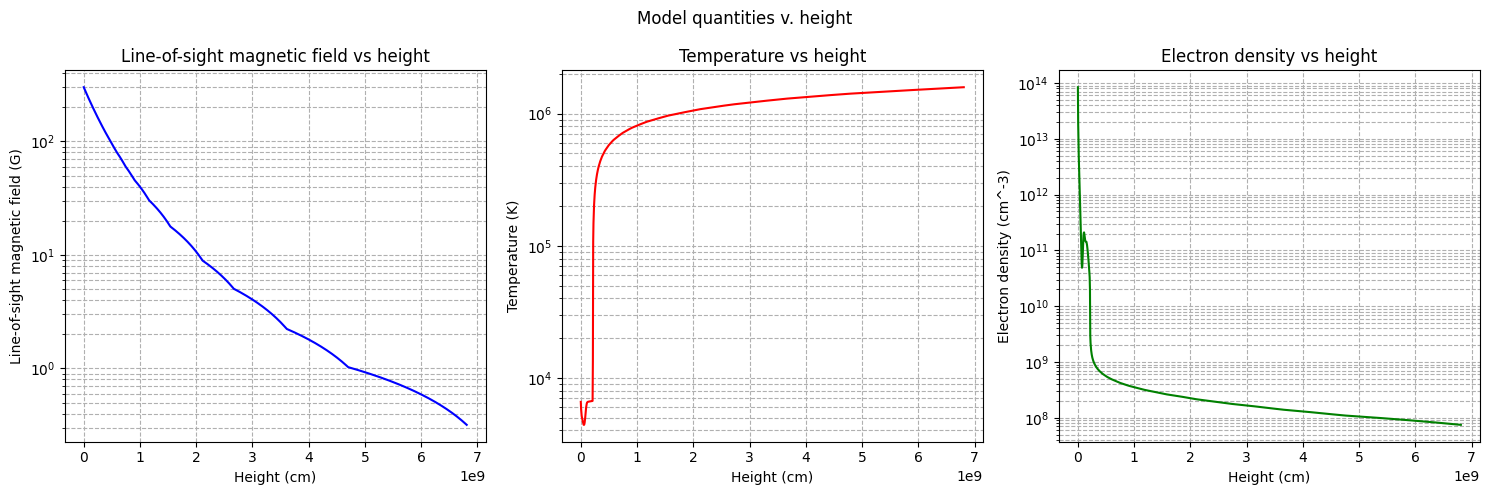

In [13]:
fig, ax = plt.subplots(1, 3, figsize=(15, 5))
ax[0].plot(heights, blos, color='blue')
ax[0].set_ylabel('Line-of-sight magnetic field (G)')
ax[0].set_yscale('log')
ax[0].set_xlabel('Height (cm)')
ax[0].grid(True, which='both', ls='--')
ax[0].set_title('Line-of-sight magnetic field vs height')
ax[1].plot(heights, temp, color='red')
ax[1].set_ylabel('Temperature (K)')
ax[1].set_yscale('log')
ax[1].set_xlabel('Height (cm)')
ax[1].grid(True, which='both', ls='--')
ax[1].set_title('Temperature vs height')
ax[2].plot(heights, ne, color='green')
ax[2].set_ylabel('Electron density (cm^-3)')
ax[2].set_xlabel('Height (cm)')
ax[2].set_yscale('log')
ax[2].grid(True, which='both', ls='--')
ax[2].set_title('Electron density vs height')
plt.suptitle('Model quantities v. height')
plt.tight_layout()
plt.show()


### Synthesize

[⎯] - creating rays... 5/5 quantities - done
[⎯] - synthesizing... 100/100 frequencies - done


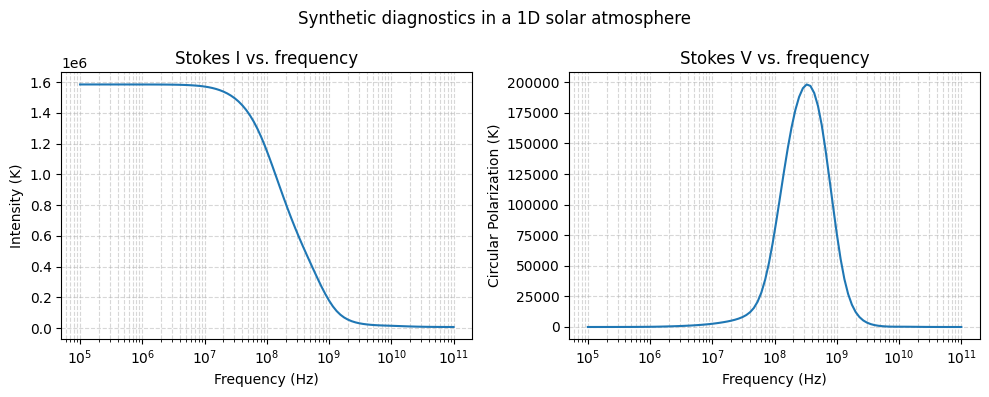

In [14]:
vs = np.logspace(5, 11, 100) # frequencies to sample
rays = pysolrad.RayCollection(temp[:-1], blos[:-1], blos[:-1], ne[:-1], dl, False) # dl uses diffs between quantities, we have 1 less data point
images = pysolrad.synthesize_range(rays, vs, dogyro=False)
fields ={'I': ('Stokes I vs. frequency', 'Intensity (K)'), 'V': ('Stokes V vs. frequency', 'Circular Polarization (K)')}
plt.figure(figsize=(10, 4))
for i, field in enumerate(fields, 1):
    vals = [getattr(img, field) for img in images]
    plt.subplot(1, 2, i)
    plt.plot(vs, vals)
    plt.title(fields[field][0])
    plt.ylabel(fields[field][1])
    plt.grid(True, which='both', linestyle='--', alpha=0.5)
    plt.xscale('log')
    plt.xlabel('Frequency (Hz)')
plt.suptitle('Synthetic diagnostics in a 1D solar atmosphere')
plt.tight_layout()
plt.show()

### 1D magnetic field inversion

$P=n\frac{2.8\times 10^6}{v}B_{\text{los}}$ where spectral index $n\equiv -\frac{\partial{\log T_b}}{\partial{\log v}}$ and $P=\frac{V}{I}$

from Chapter 6 of [Solar and Space Weather Radio Physics](https://drive.google.com/file/d/1nPEj6RIKA_eOtnwODCnCgedhT0LWunM2/view)

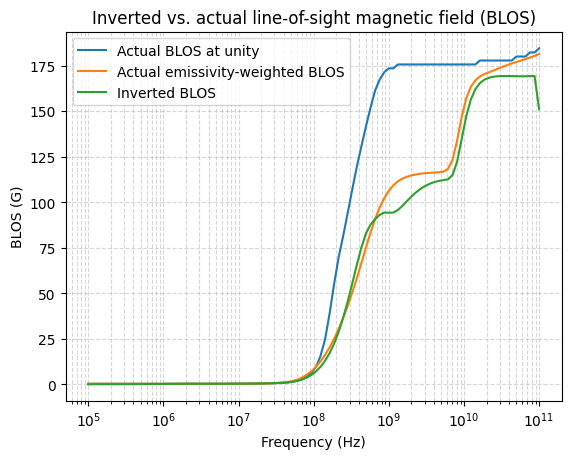

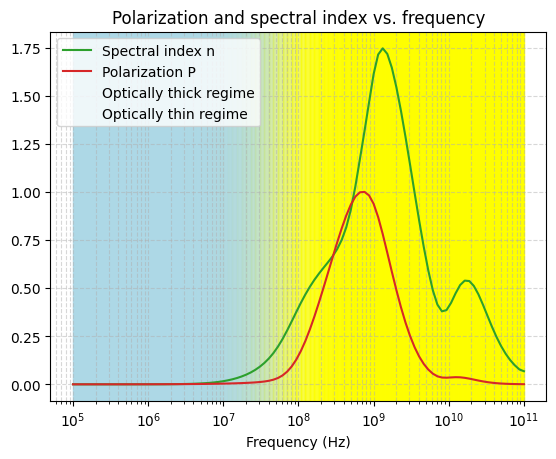

In [15]:
inverted_blos = pysolrad.invert_blos(images)
blos_at_unity = pysolrad.get_quantity_at_unity(rays, 'blos', images)
spectral_idx = pysolrad.get_spectral_idx(images)
P = images.V/images.I

plt.figure()
plt.plot(vs, blos_at_unity, label='Actual BLOS at unity')
plt.plot(vs, images.weighted_blos, label='Actual emissivity-weighted BLOS')
plt.plot(vs, inverted_blos, label='Inverted BLOS')
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.xscale('log')
plt.xlabel('Frequency (Hz)')
plt.ylabel('BLOS (G)')
plt.legend()
plt.title('Inverted vs. actual line-of-sight magnetic field (BLOS)')
plt.show()

plt.figure()
plt.plot(vs, spectral_idx, color='tab:green', label='Spectral index n')
P_normalized = (P - P.min()) / (P.max() - P.min())
plt.plot(vs, P_normalized, color='tab:red', label='Polarization P')
unity = np.array([img.unity for img in images])
unity_normalized = (unity - unity.min()) / (unity.max() - unity.min())
label_done = False
for i in range(len(vs) - 1):
    plt.axvspan(vs[i], vs[i+1], color='lightblue', alpha=unity_normalized[i], label='Optically thin regime' if i == len(vs) - 2 else None)
    plt.axvspan(vs[i], vs[i+1], color='yellow', alpha=1-unity_normalized[i], label='Optically thick regime' if i == 0 else None)
# plt.plot(vs, unity_normalized)
plt.grid(True, which='both', linestyle='--', alpha=0.5)
plt.title('Polarization and spectral index vs. frequency')
plt.xlabel('Frequency (Hz)')
plt.legend()
plt.xscale('log')
plt.show()

### Temperature-brightness contribution by layer

How much does each layer of the atmosphere (height) comparably contribute to the total temperature brightness (Stokes IV) for each frequency?

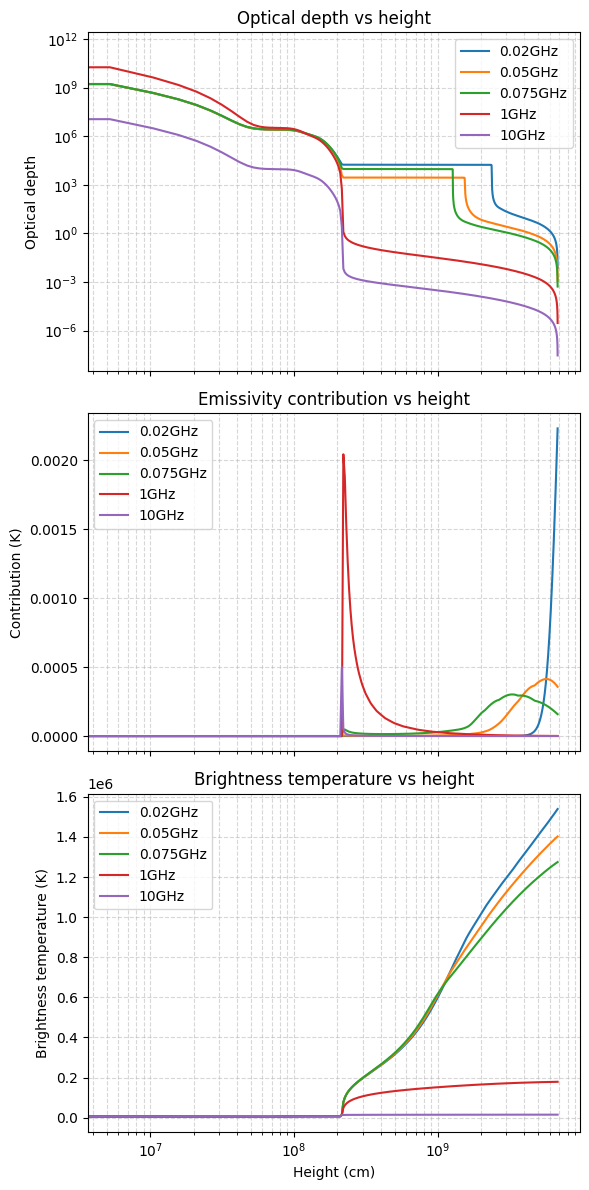

In [16]:
fs = []
vs = [0.02e9, 0.05e9, 0.075e9, 1e9, 10e9]
for v in vs:
    fs.append(pysolrad.get_contribution_function(rays, v, False))

fig, axs = plt.subplots(3, 1, figsize=(6, 12), sharex=True)

for i in range(len(vs)):
    axs[0].plot(fs[i].height, fs[i].tau, label=str(fs[i].v.to('GHz')))
axs[0].set_yscale('log')
axs[0].set_xscale('log')
axs[0].set_ylabel('Optical depth')
axs[0].set_title('Optical depth vs height')
axs[0].grid(True, which='both', linestyle='--', alpha=0.5)
axs[0].legend()

for i in range(len(vs)):
    axs[1].plot(fs[i].height, fs[i].cf, label=str(fs[i].v.to('GHz')))
axs[1].set_xscale('log')
# axs[1].set_yscale('log')
# axs[1].set_ylim(1e-6)
axs[1].set_ylabel('Contribution (K)')
axs[1].set_title('Emissivity contribution vs height')
axs[1].grid(True, which='both', linestyle='--', alpha=0.5)
axs[1].legend()

for i in range(len(vs)):
    axs[2].plot(fs[i].height, fs[i].tb, label=str(fs[i].v.to('GHz')))
axs[2].set_xscale('log')
axs[2].set_ylabel('Brightness temperature (K)')
axs[2].set_title('Brightness temperature vs height')
axs[2].grid(True, which='both', linestyle='--', alpha=0.5)
axs[2].legend()

axs[2].set_xlabel('Height (cm)')

plt.tight_layout()
plt.show()